# Analyza dat

> Task: Analyza dat - Treba vediet kolko tych dat mate, ake maju vlastnosti. Tu je cielom najma spoznat vas dataset, aby ste lepsie chapali obmedzenia, ktore z neho vyplyvaju.


Whole dataset is built from many datasources which are mentionded in `dataset.md`


Images we currently use need about ~240 GB of storage

```
$ du -sh Flickr2K/Flickr2K_HR google_oid/ div2k/
11G	Flickr2K/Flickr2K_HR
225G	google_oid/
3.8G	div2k/
```



In total we have about 150K images


```
$ find ./ -type d | xargs ls -l | wc -l
157663
```



For now we will use only Flickr2K and div2K datasets. We extracted image metadata from via `file` command and then we saved it do CSV file


```
echo 'dataset,dataset_name,name,type,width,height,depth,color,interlacing' > ~/images.csv
```

```
file Flickr2K/Flickr2K_HR/* div2k/DIV2K_train_HR/* div2k/DIV2K_valid_HR/* | tr '/' ',' | tr ':' ',' | sed "s/ x /,/"  >> ~/images.csv
```



## Dataset

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

pd.options.display.max_columns = None

In [0]:
#upload file form

from google.colab import files
uploaded = files.upload()
import io
df = pd.read_csv(io.BytesIO(uploaded['images.csv']))


Saving test.csv to test.csv


In [0]:
# or download from server
!wget https://static.dthi.eu/datasets/metadata.csv
df = pd.read_csv('metadata.csv')

--2019-11-17 19:37:59--  https://static.dthi.eu/datasets/metadata.csv
Resolving static.dthi.eu (static.dthi.eu)... 88.212.57.17
Connecting to static.dthi.eu (static.dthi.eu)|88.212.57.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326646 (319K) [application/octet-stream]
Saving to: ‘metadata.csv’

metadata.csv        100%[===================>] 318.99K   387KB/s    in 0.8s    

2019-11-17 19:38:01 (387 KB/s) - ‘metadata.csv’ saved [326646/326646]



In [0]:
df.head()

dataset dataset_name        name             type   width  height   depth  \
0  Flickr2K  Flickr2K_HR  000001.png   PNG image data  2040.0  1356.0   8-bit   
1  Flickr2K  Flickr2K_HR  000002.png   PNG image data  2040.0  1356.0   8-bit   
2  Flickr2K  Flickr2K_HR  000003.png   PNG image data  2040.0  1356.0   8-bit   
3  Flickr2K  Flickr2K_HR  000004.png   PNG image data  1608.0  1200.0   8-bit   
4  Flickr2K  Flickr2K_HR  000005.png   PNG image data  2040.0  1356.0   8-bit   

       color      interlacing  
0  color RGB   non-interlaced  
1  color RGB   non-interlaced  
2  color RGB   non-interlaced  
3  color RGB   non-interlaced  
4  color RGB   non-interlaced

In [0]:
df.describe()

width       height
count   267.000000   267.000000
mean   1930.831461  1478.831461
std     236.616909   279.167313
min    1140.000000   816.000000
25%    2028.000000  1356.000000
50%    2040.000000  1356.000000
75%    2040.000000  1524.000000
max    2040.000000  2040.000000

Our biggest image source is Flickr dataset

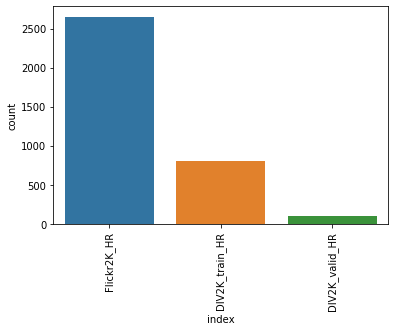

In [0]:
plt.xticks(rotation=90)
education_data = df["dataset_name"].value_counts().rename('count').reset_index()
sns.barplot(x="index", y="count", data=education_data)

We want to simplify input for neural network so we crop image to square.

In [0]:
cropped_values = df[['width','height']].min(axis=1).value_counts().rename('count').reset_index()

cropped_values.head()

index  count
0   1356   1693
1   1524    415
2   1140    219
3   1344    146
4   1536     71

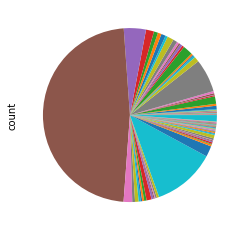

In [0]:
cropped_values['count'].groupby(cropped_values['index']).sum().plot(kind='pie', labels=None)
plt.show()

Our image dataset consists only from color photos. We can expect that our model would not work correctly on grayscale images (Grayscale images have only one channel)

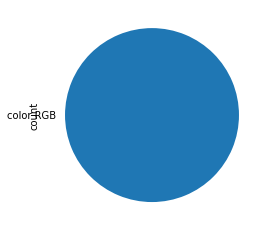

In [0]:
color = df['color'].value_counts().rename('count').reset_index()
color['count'].groupby(color['index']).sum().plot(kind='pie')
plt.show()

### Sample image

Load sample image and our resizer which we are using in project 

In [0]:
%%bash
wget https://static.dthi.eu/datasets/Flickr2K/Flickr2K_HR/001835.png
wget https://raw.githubusercontent.com/unknow112/NSIETE-project-2019/master/resizer.py

--2019-11-16 01:13:04--  https://static.dthi.eu/datasets/Flickr2K/Flickr2K_HR/001835.png
Resolving static.dthi.eu (static.dthi.eu)... 88.212.57.17
Connecting to static.dthi.eu (static.dthi.eu)|88.212.57.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4610311 (4.4M) [image/png]
Saving to: ‘001835.png’

     0K .......... .......... .......... .......... ..........  1%  184K 24s
    50K .......... .......... .......... .......... ..........  2%  184K 24s
   100K .......... .......... .......... .......... ..........  3% 29.5M 16s
   150K .......... .......... .......... .......... ..........  4% 57.6M 12s
   200K .......... .......... .......... .......... ..........  5%  185K 14s
   250K .......... .......... .......... .......... ..........  6% 37.1M 11s
   300K .......... .......... .......... .......... ..........  7% 25.1M 10s
   350K .......... .......... .......... .......... ..........  8%  187K 11s
   400K .......... .......... .......... .......... 

In [0]:
from importlib import reload
import resizer
reload(resizer)
from resizer import *
from PIL import Image
from IPython.display import display

We load original image

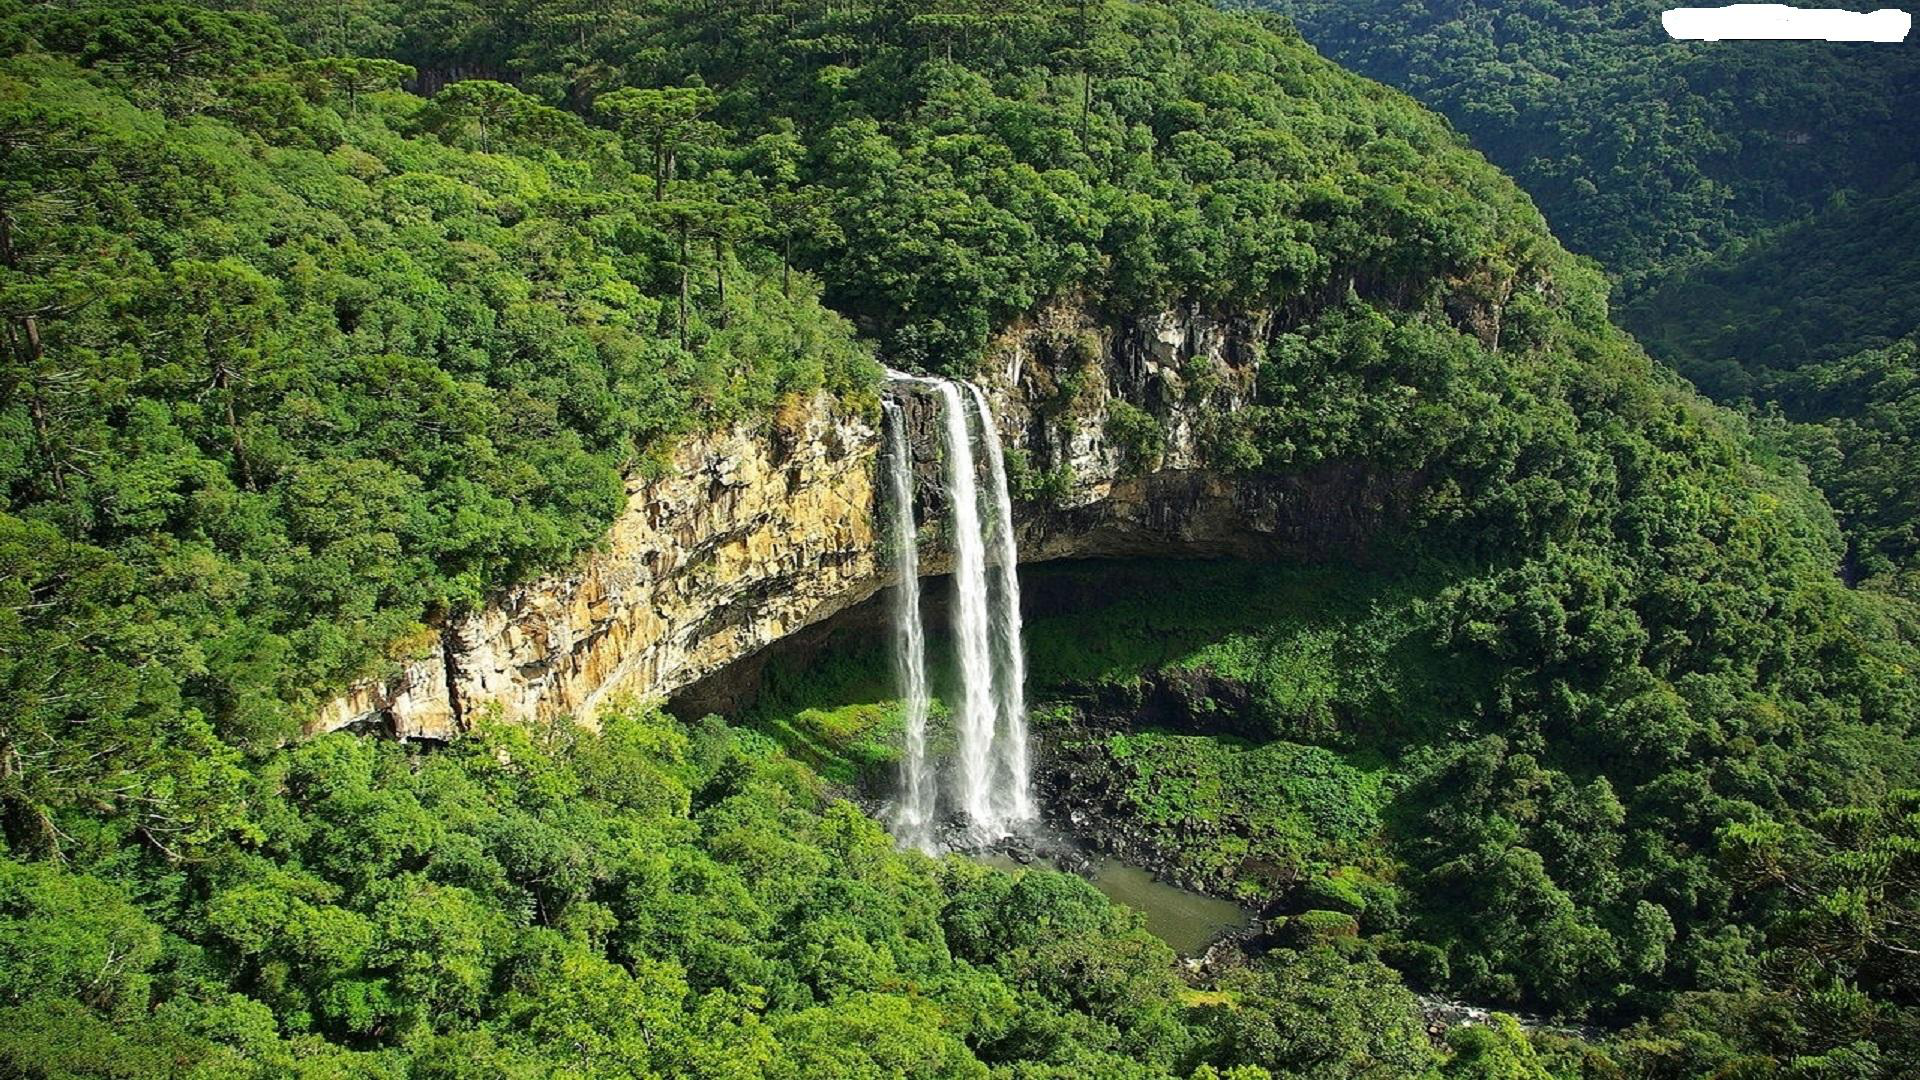

In [0]:
image = Image.open('001835.png')
display(image)

Crop it to square via our crop function

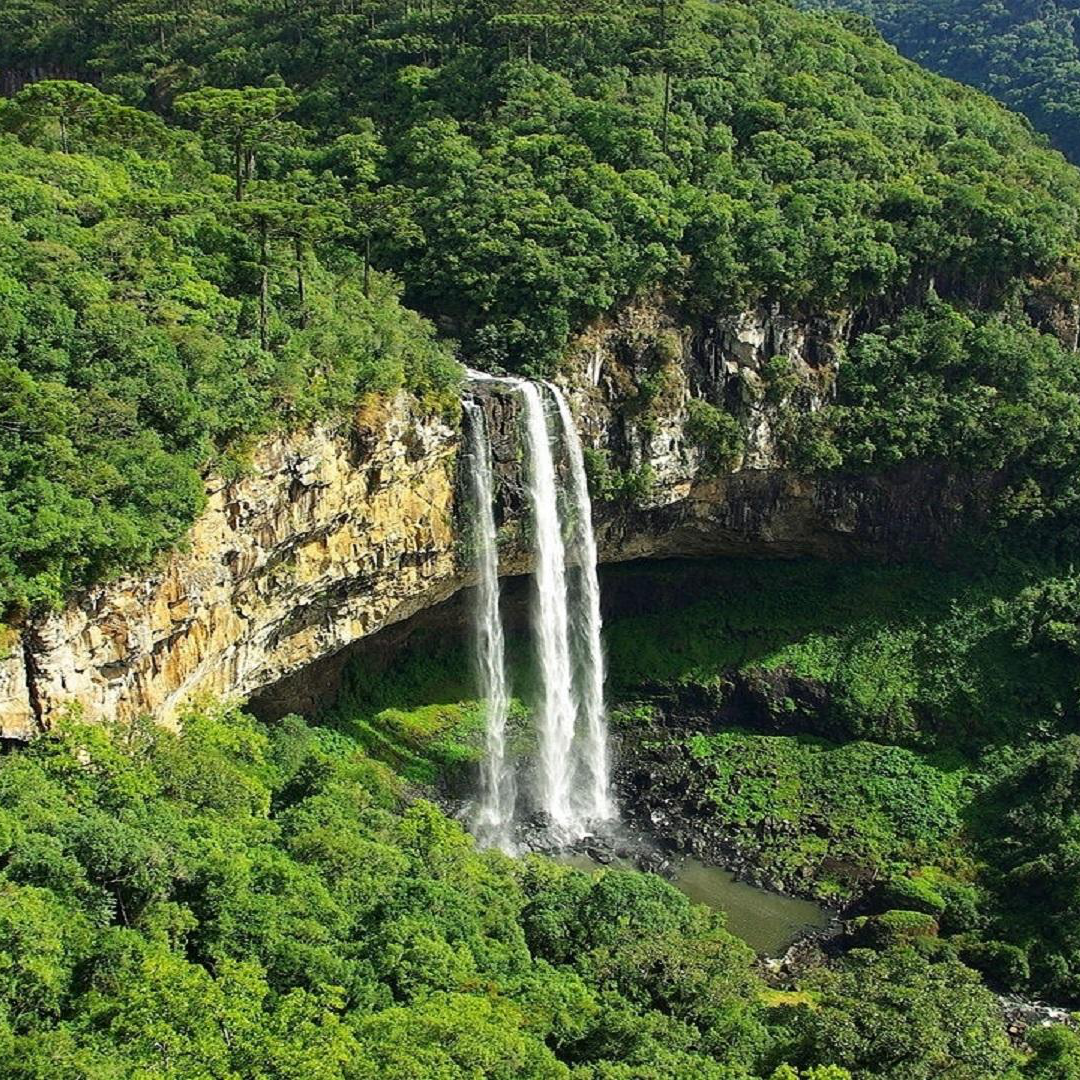

In [0]:
cropped_image = square(image)
display(cropped_image)

As we see image change it's size

In [0]:
image.size, cropped_image.size

((1920, 1080), (1080, 1080))

After crop, we resize them to size 32x32 px (in first iteration).

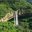

In [0]:
display(resize(32, cropped_image))


**GAN Theory**

Resized images are used as input for Generator.
Cropped images along with generated images are used as input for Discriminator.